# Ensemble trends: pr + evspsbl

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })
warnings.filterwarnings('ignore')

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'pr'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
conf_evspsbl = [v for v in libs.vars.variables() if v['variable_id'] == 'evspsbl'][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id
)

ensemble_time_series_pr = libs.local.get_ensemble_series(variable_id, experiment)
ensemble_time_series_evspsbl = libs.local.get_ensemble_series('evspsbl', experiment)

for key in ensemble_time_series_evspsbl:
    ensemble_time_series_evspsbl[key].attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)) }


obs_arr = []
for obs in conf['obs']:
    obs_data = libs.local.get_obs(**obs)

    obs_arr.append({
        'color': obs_data.attrs['color'],
        'data': obs_data * 86400 / 100, # Convert s -> d, fix factor 100
        'label': obs_data.attrs['label']
    })
    
for obs in conf_evspsbl['obs']:
    obs_data = libs.local.get_obs(**obs)

    obs_arr.append({
        'color': obs_data.attrs['color'],
        'data': obs_data * -86400 / 100, # Convert s -> d, invert, fix factor 100
        'label': obs_data.attrs['label']
    })
    
obs_ts, obs_ts_smooth = libs.ensemble.time_series_weighted(
    obs_arr,
    weight,
    fillna=None,
    weighting_method=conf['weighting_method'],
    weighting_process=conf['weighting_process']
)

obs_ts_keys = {}
for i, item in enumerate(obs_ts):
    key = ' '.join([item['label'], item['data'].name])
    processed_data = item['data']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    processed_data.attrs['color'] = item['color']
    processed_data.attrs['label'] = key
    
    # Groupby + mean to resample from monthly time to year, then add to ensemble datasets
    obs_ts_keys[key] = processed_data


ds_obs = xarray.Dataset(data_vars=obs_ts_keys)
ds_obs['ERA5 tp'].attrs['plot_kwargs'] = { 'linewidth': 3, 'zorder': 10 }
ds_obs['ERA5 e'].attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)), 'linewidth': 3, 'zorder': 10 }

## Time series

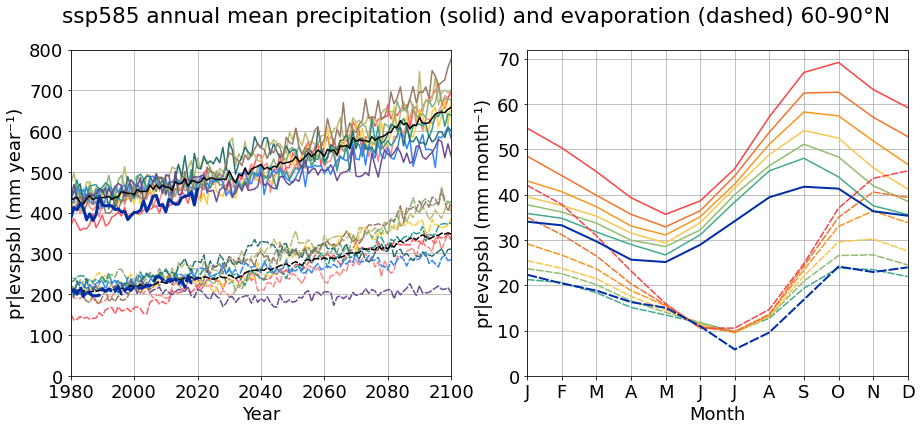

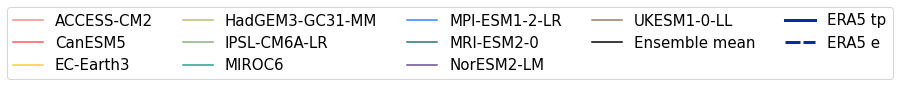

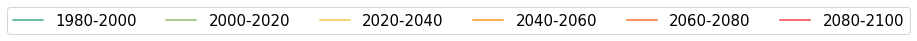

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
fig.suptitle(
    f'''{experiment} annual mean precipitation (solid) and evaporation (dashed) 60-90°N'''
)

vars_series = [
    { 'calc_mean': True, 'data': ensemble_time_series_pr },
    { 'calc_mean': True, 'data': ensemble_time_series_evspsbl },
    { 'calc_mean': False, 'data': ds_obs },
]
plot_arr = []
variables_keys = []
for item in vars_series:
    item_processed = item['data'].groupby('time.year').mean('time')
    item_processed *= 360 # convert to annual

    if item['calc_mean']:
        item_processed = libs.ensemble.calc_variable_mean(item_processed)

    variables_keys.extend(list(item_processed))
    plot_arr.append(item_processed)

variables_keys = list(dict.fromkeys(variables_keys))
plot_arr[1]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)) }

libs.plot.time_series_from_vars(
    plot_arr,
    ax=axes[0],
    fig=fig,
    show_legend=False,
    xattr='year',
    variables=variables_keys,
    ylabel='pr|evspsbl (mm year⁻¹)',
    yrange=(0, 800)
);

arr = []
for item in vars_series[0:-1]:
    for s in libs.vars.time_slices_20y():
        s_label = s['label']
        data_slice = (item['data'] * 30).sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']

        arr.append(data_slice)
        

obs_compare_slice = libs.vars.time_slices_20y()[0]['slice']
for ds_var in ds_obs:
    # Not ensemble mean, but using name for ease in monthly variability plot
    obs_ts_slice = xarray.Dataset(
        data_vars={ 
            'Ensemble mean': (ds_obs[ds_var] * 30).sel(**obs_compare_slice).groupby('time.month').mean('time')
        }
    )
    obs_ts_slice['Ensemble mean'].attrs['plot_kwargs']['linewidth'] = 2
    arr.append(obs_ts_slice)

libs.plot.monthly_variability(
    arr,
    ax=axes[1],
    fig=fig,
    legend_below=True,
    show_legend=False,
    variables=['Ensemble mean'],
    ylabel='pr|evspsbl (mm month⁻¹)',
    yrange=(0, 72)
);

libs.plot.legend_standalone(
    fig,
    legend_confs=[
        { 'ncol': 5, 'exclude': [] },
        { 'ncol': 6, 'exclude': ds_obs.keys() },
    ]
)

In [5]:
pr_annual_mean = plot_arr[0]
evspsbl_annual_mean = plot_arr[1]

for obj in [{ 'ds': pr_annual_mean, 'key': 'PR' }, { 'ds': evspsbl_annual_mean, 'key': 'EVSPSBL' }]:
    print('-----', obj['key'], '-----')
    ds = obj['ds']
    
    libs.analysis.calc_diffs(ds, unit='mm', relative=True)    

----- PR -----
ACCESS-CM2
-> 1980-2010: 430.79mm
-> 2080-2100: 624.36mm
-> delta: 44.93%
CanESM5
-> 1980-2010: 390.62mm
-> 2080-2100: 663.80mm
-> delta: 69.94%
EC-Earth3
-> 1980-2010: 444.46mm
-> 2080-2100: 624.36mm
-> delta: 40.47%
HadGEM3-GC31-MM
-> 1980-2010: 466.47mm
-> 2080-2100: 668.42mm
-> delta: 43.29%
IPSL-CM6A-LR
-> 1980-2010: 454.61mm
-> 2080-2100: 655.89mm
-> delta: 44.27%
MIROC6
-> 1980-2010: 460.92mm
-> 2080-2100: 611.15mm
-> delta: 32.59%
MPI-ESM1-2-LR
-> 1980-2010: 453.51mm
-> 2080-2100: 564.27mm
-> delta: 24.42%
MRI-ESM2-0
-> 1980-2010: 455.60mm
-> 2080-2100: 589.99mm
-> delta: 29.50%
NorESM2-LM
-> 1980-2010: 456.67mm
-> 2080-2100: 547.43mm
-> delta: 19.88%
UKESM1-0-LL
-> 1980-2010: 435.24mm
-> 2080-2100: 700.89mm
-> delta: 61.03%
Ensemble mean
-> 1980-2010: 444.89mm
-> 2080-2100: 625.06mm
-> delta: 40.50%

Range 19.875710327828187 - 69.93604385613682
Median 44.905877091982504
Mean 41.03346981274005

----- EVSPSBL -----
ACCESS-CM2
-> 1980-2010: 199.72mm
-> 2080-2100: 3